Compute the maximum voltage rise (on the network, using Power flow) and convert it in a binary variable to use to train the RNN to predict whether a voltage rise will occur or not in the next period . 

See [VoltageRiseBin_Train](voltageRiseBin_Train.ipynb) for the training and [VoltageRiseBin_Pred](voltageRiseBin_Pred.ipynb) for the simulation on the testing set 

---

In [1]:
def block_pf_Opf(par_engines, 
                 pred_model_f=None
                ):
    """
Execute a power flow or an optimal power flow depending on the opf_status that is extracted
from the one of the parallel engine object and return a dataFrame. 
If opf_status is 'Both', the function is used as the block PF/OPF and thereforth 
the returned dataframe consist of  
If opf_status is False, the function is used as the block PF, the returned dataframe contains 
only the maximum voltage rise observed on the network after the control is implemented.
  
Parameters
----------
par_engines: (oriCs.CreateParEngines(n_engines))
    Parallel engines object. 
pred_model_f: (str) optional, default to None
    'Pers' ==> Using persistence model

    """
    
    
    
    # Note that all the variables used in the parallel running are already sent to the local space of each engine
    if pred_model_f == 'Pers': 
    # Run problem in parallel
        %px par_run_Results = [par_oriFunctions.run_powerflow_at(net_civaux, cur_period+1, net_civaux_hv_activated_bus, sum_max_main_network,  dict_df_sgenLoad, vm_mu_max, opf_status, pred_model) for cur_period in period_part]
    else:
        %px par_run_Results = [par_oriFunctions.run_powerflow_at(net_civaux, cur_period, net_civaux_hv_activated_bus, sum_max_main_network,  dict_df_sgenLoad, vm_mu_max, opf_status) for cur_period in period_part]
        
    # Gather the results of all the engines in a unique variable
    results = par_engines.gather_results('par_run_Results')
    
    # Wait 2seconds time for gathering the results of parralel computing  
    time.sleep(2) 

    # return depends on opf_status defined in parallel engines
    if par_engines.get_opf_status() == 'Both': 
        extracted_results = par_engines.get_results_asDf() # Extract results
        return extracted_results
    
    elif par_engines.get_opf_status() == False: 
        # Put data in dataframe
        max_vm_pu_rnn_df = pd.DataFrame(data=np.array(results), 
                                        index=par_engines.get_run_periodIndex(), columns=['vm_pu_max_pf'],)
        return max_vm_pu_rnn_df
    else: pass


#### Import modules

In [2]:
import pandas as pd
import pandapower as pp
import matplotlib.pyplot as plt
import numpy as np
import ipyparallel as ipp

from tqdm import tqdm # Profiling 
import seaborn as sbn
import pickle, sys, importlib,  time
import os
from pickle import load
import tensorflow as tf
import joblib

In [3]:
function_folder = 'py_files/' 
# Add function folder to path if it is not already
if function_folder not in sys.path: sys.path.append(function_folder)

import oriFunctions as oriFc
import myClass as oriCs
from oriFunctions import network_folder, excel_folder, py_folder, Δt, attr_list, train_split_date, train_split_date

In [4]:
net_civaux=pp.from_pickle(f'{network_folder}CIVAUX.p')
net_stlaurent=pp.from_pickle(f'{network_folder}ST LAURENT.p')

# Load networks
networks = oriCs.InitNetwork(net_stlaurent, net_civaux)

# To use later in functions 
sum_max_main_network = networks.get_sum_max_p_wm_higherNet()


# Compute the total of BT prod and Load on St Laurent
sum_max_p_mw_StLaurent_prodBT = sum_max_main_network[0]
sum_max_p_mw_StLaurent_load = sum_max_main_network[1]

#### Import Cleaned data files for component of the network

In [5]:
df_data = joblib.load(network_folder+'CleanedData.pkl')

# Extract only dailight period i.e. from 07am to 7PM
# The daylight period is considered to be defined betwenn 07am and 7Pm excluded. 
h_start_end = ('06:00','19:50') # for the persistance model, the previous period i.e. 06:50 
                                # is needed to compute the first instant i.e. 07:00
per_index = df_data.index
per_daylight = ( pd.Series(index=per_index.to_timestamp(), dtype=object).between_time(*h_start_end) ).index.to_period('10T')
day_tot_per = len(per_daylight[(per_daylight.year==2020)&(per_daylight.month==1)&(per_daylight.day==1)])


# Put all the data in a unique dataframe
df_data = df_data.loc[per_daylight]

# # Extract only the relavant testing set since the training set covers the first part of the data
df_final = df_data[df_data.index<'2022 06 02']
per_index = df_final.index
per_index2 = ( pd.Series(index=per_index.to_timestamp(), dtype=object
                           ).between_time('06:00','19:50') ).index.to_period('10T')


#### Data extraction on the network

In [7]:
net_civaux_hv_bus = networks.get_lowerNet_hv_bus_df() # Extract HV bus in the network

pp.runpp(net_civaux) # Run network 

# Get the index of all the activated bus in the network
activated_bus_index = list(net_civaux.res_bus.vm_pu[net_civaux.res_bus.vm_pu.notna()].index)

# Extract the HV bus from the list of activated bus 
net_civaux_hv_activated_bus = [i for i in activated_bus_index 
                               if i in net_civaux_hv_bus.index]

# redefine data given final dataframe
df_prodHT = df_final[['P0013','P0018','P0100']] 
df_prod_bt_total = df_final[['Prod_BT']]
df_cons_total = df_final[['Cons']]

# Define a dict 
dict_df_sgenLoad = dict({'df_prodHT':df_prodHT, 
                         'df_prod_bt_total':df_prod_bt_total, 
                         'df_cons_total':df_cons_total } )

#### Start Parallel engines

In [8]:
n_engines = os.cpu_count() - 1  # Define total number of parallel engines to use. 
# Make sure it is lower than the total number of cores in the computer otherwise 
# no ressources is available to work when the simulation is running. 
parEngines = oriCs.CreateParEngines(n_engines)
                   

Starting 7 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/7 [00:00<?, ?engine/s]

#### Load network

In [9]:
net_civaux=pp.from_pickle(f'{network_folder}CIVAUX.p') # Reload network with new name 

# Add a controllable line to the static generators
net_civaux.sgen['controllable'] = False 

# Set the producer P0100 as a controllable load
net_civaux.sgen['controllable'][net_civaux.sgen.name=='P0100'] = True

# Add Missing columns to be able to un an opf 
net_civaux.sgen[['min_p_mw', 'min_q_mvar', 'max_q_mvar']]=0.

# Rename data in bus network because the names do not correspond to the parameters in pandapower 
net_civaux.bus.rename({'max_vw_pu':'max_vm_pu',}, axis=1, inplace=True)

net_civaux.bus.drop(['max_vm', 'min_vm'], axis=1, inplace=True)    # Delete useless parameters
net_civaux_hv_bus = list(net_civaux.bus.groupby('vn_kv'))[1][1]   # Extract HV bus in the network

pp.runpp(net_civaux) # Run network 

# Get the index of all the activated bus in the network
activated_bus_index2 = list(net_civaux.res_bus.vm_pu[net_civaux.res_bus.vm_pu.notna()].index)

# Extract the HV bus from the list of activated bus 
net_civaux_hv_activated_bus = [i for i in activated_bus_index2 
                               if i in net_civaux_hv_bus.index]

#### Add maximum voltage constraints on the Buses in the network 

In [10]:
vm_mu_max, vm_mu_min = 1.0250, 0.95  # Choosen 

# net_civaux.bus.max_vm_pu[net_civaux.bus.max_vm_pu.notna()] = vm_mu_max
net_civaux.bus.max_vm_pu[net_civaux_hv_activated_bus] = vm_mu_max
net_civaux.bus.min_vm_pu[net_civaux_hv_activated_bus] = vm_mu_min


In [11]:
# Add negative cost to usability of sgen P0100 so its usage can be maximised while respecting the constraints on the network
cost_sgen_p0100 = pp.create_poly_cost(net_civaux,23,'sgen', cp1_eur_per_mw=-1)
# net_civaux.poly_cost.cp1_eur_per_mw.at[cost_sgen_p0100]=-0.5
net_civaux.poly_cost

,element,et,cp0_eur,cp1_eur_per_mw,cp2_eur_per_mw2,cq0_eur,cq1_eur_per_mvar,cq2_eur_per_mvar2
0,23,sgen,0.0,-1.0,0.0,0.0,0.0,0.0


In [12]:
opf_status = False

# Create a dictionnary containing all the varible that will be used by each client or engine
pred_model = None

parameters_dict = dict({'net_civaux':net_civaux, 
                        'net_civaux_hv_activated_bus':net_civaux_hv_activated_bus, 
                        'sum_max_main_network':sum_max_main_network, 
                        'vm_mu_max':vm_mu_max,
                        'pred_model':pred_model
                         })

# Create dictionnary of main variable i.e. Prod BT, HT, Cons to used in parallel engines 
upscaling_coef, coef_add_bt = 4.,0 
P0100_max = 4. 

dict_df_sgenLoad = oriFc.createDict_prodHtBt_Load(df_final,
                                               upscaling_coef, coef_add_bt,
                                               sum_max_p_mw_StLaurent_prodBT,P0100_max )

df_prodHT = dict_df_sgenLoad['df_prodHT']


# Send all the created variables into local spaces of each engine.
parEngines.sendVar_to_localSpace(df_prodHT.index, opf_status, dict_df_sgenLoad, parameters_dict, 0 )


importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


In [13]:
pf_opf_block_result = block_pf_Opf(parEngines)    


%px:   0%|          | 0/7 [00:00<?, ?tasks/s]

In [14]:
# Put data in dataframe
max_vm_pu_df = pf_opf_block_result

In [15]:
bin_voltage_rise = [1 if cur_elm == True 
                    else 0 
                    for cur_elm in (max_vm_pu_df.vm_pu_max_pf > vm_mu_max).values ]

In [16]:
max_vm_pu_df['Volt_Rise_Bin'] = bin_voltage_rise

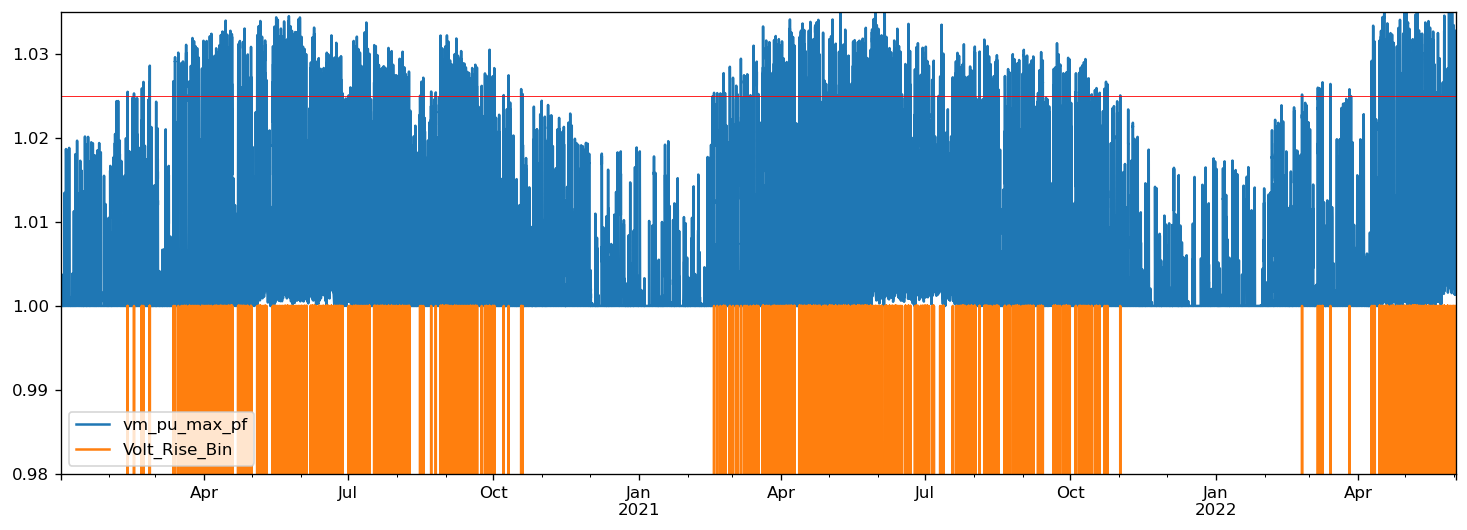

In [17]:
fig, axx = plt.subplots(figsize=(15,5), dpi=120)
max_vm_pu_df.plot(ax=axx)
plt.ylim((0.98,1.035))
plt.axhline(vm_mu_max, color='red', lw=0.5)

In [35]:
max_vm_pu_df.rename(columns={'vm_pu_max_pf':'known'}, inplace=True)# Rename columns
joblib.dump(max_vm_pu_df, 'pickle_files/simulationResults/Binary_Voltage_Rise.pkl')

['pickle_files/simulationResults/Binary_Voltage_Rise.pkl']

Failed to remove C:\Users\j.prince-agbodjan\.ipython\profile_default\log\ipcontroller-1672907899-wc3t-19360.log: [WinError 32] Le processus ne peut pas accéder au fichier car ce fichier est utilisé par un autre processus: 'C:\\Users\\j.prince-agbodjan\\.ipython\\profile_default\\log\\ipcontroller-1672907899-wc3t-19360.log'
Controller stopped: {'exit_code': 15, 'pid': 19816, 'identifier': 'ipcontroller-1672907899-wc3t-19360'}
Stopping engine(s): 1672907901
engine set stopped 1672907901: {'engines': {'0': {'exit_code': 15, 'pid': 10960, 'identifier': '0'}, '2': {'exit_code': 15, 'pid': 19532, 'identifier': '2'}, '3': {'exit_code': 15, 'pid': 16908, 'identifier': '3'}, '1': {'exit_code': 15, 'pid': 28232, 'identifier': '1'}, '4': {'exit_code': 15, 'pid': 20680, 'identifier': '4'}, '5': {'exit_code': 15, 'pid': 23356, 'identifier': '5'}, '6': {'exit_code': 15, 'pid': 23832, 'identifier': '6'}}, 'exit_code': 15}


Stopping cluster <Cluster(cluster_id='1672907899-wc3t', profile='default', controller=<after>, engine_sets=['1672907901'])>
